In [6]:
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os

In [7]:
import wandb
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch import Trainer
import lightning.pytorch as pl
from torchmetrics.functional import accuracy

from lightning.pytorch.callbacks import ModelCheckpoint

wandb.login(key='fd85ae65c5e04fb6fea4d31c1180348532db32d6')
wandb_project= 'EE22M008_Assignment_02'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ee22m008. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\balaj\.netrc


In [3]:
train_dir='C:\\Users\\balaj\\Documents\\Assignment_02\\inaturalist_12K\\train'
test_dir='C:\\Users\\balaj\\Documents\\Assignment_02\\inaturalist_12K\\val'
categories=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

In [4]:
# Print the number of images in each folder
for folder in categories:
    folder_path = os.path.join(train_dir, folder)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        print(f"Folder '{folder}' contains {num_images} images.")

Folder 'Amphibia' contains 1000 images.
Folder 'Animalia' contains 1000 images.
Folder 'Arachnida' contains 1000 images.
Folder 'Aves' contains 1000 images.
Folder 'Fungi' contains 1000 images.
Folder 'Insecta' contains 1000 images.
Folder 'Mammalia' contains 1000 images.
Folder 'Mollusca' contains 1000 images.
Folder 'Plantae' contains 1000 images.
Folder 'Reptilia' contains 1000 images.


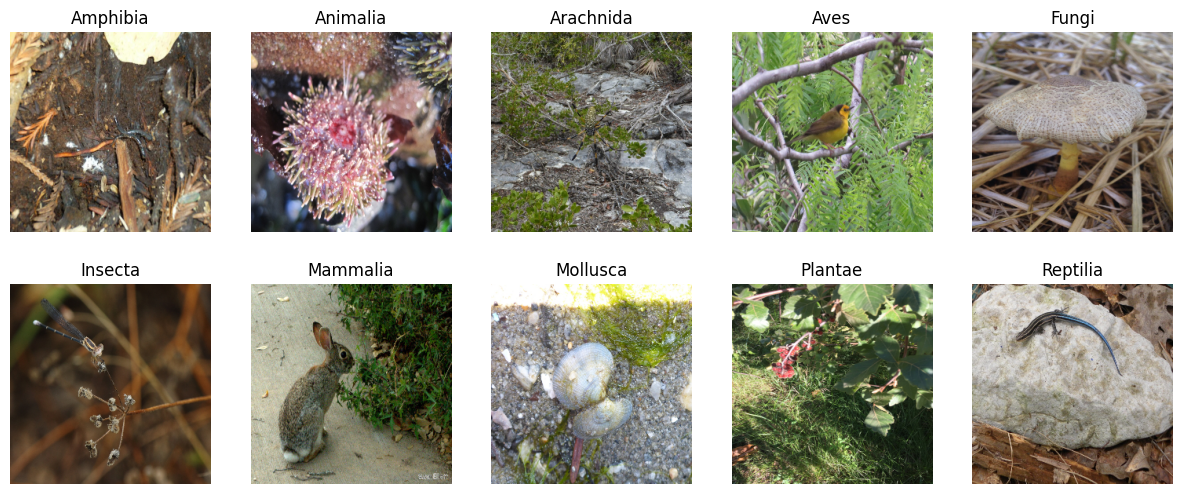

In [5]:
#Visualizing image in each class
wandb.init(project=wandb_project)
fig = plt.figure(figsize=(15,6))
rows,columns=2,5
i=1
for category in categories:
  dir=os.path.join(train_dir,category)
  for img in os.listdir(dir):
    img_path=(os.path.join(dir,img))
    imgs=mpimg.imread(img_path)
    new_img=cv2.resize(imgs,(256,256))
    wandb.log({"Image": [wandb.Image(new_img, caption=category)]})
    fig.add_subplot(rows,columns,i)
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(category)
    i+=1
    break
wandb.finish()


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


**To determine the total number of computation in the CONV5 neural network**

In [6]:
num_channels, num_filters= 3, [16, 32, 64, 128, 256]    # input channel RGB= 3 and no. of filters in each convolution layer
num_conv_blocks= 5 # 5 Convolution Layer
num_fc_layers=2   # No. of Fully Connected Layer
dense_neurons=[120, 84]   # Dense neurons in each FC layer
filter_size=5   # Kernel size for convolution

# Building Convolution Layer
conv_layers= nn.ModuleList()
for i in range(num_conv_blocks):
  # Determine input channels for the current conv layer
  in_channels = num_filters[i-1] if i > 0 else num_channels
  conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=num_filters[i], kernel_size=filter_size)
  conv_layers.append(conv_layer)
relu= nn.ReLU()
pooling_layer= nn.MaxPool2d(kernel_size=2, stride=2)
softmax= nn.Softmax(dim=1)

In [7]:
def forward(x):
  # Pass input through convolutional layers
  print("Input image shape: ", x.shape)
  for i, layer in enumerate(conv_layers):
    x = layer(x)
    print(f"Convolution layer {i+1}:", x.shape)
    x = relu(x)
    x = pooling_layer(x)
    print(f"Pooling layer {i+1}:", x.shape)

  # Flatten the output from the last convolution layers
  x = x.view(x.size(0), -1)
  print(f"Flattened after 5 CONV Block", x.shape)

  # Pass through fully connected layers
  for i in range(num_fc_layers):
    fc = nn.Linear(x.size(1), dense_neurons[i])
    x = fc(x)
    print(f"Fully Connected layer {x.shape} since the dense neurons: {dense_neurons[i]}")
    x = relu(x)
    print(x.shape)

  # Apply softmax activation for classification
  last_layer= nn.Linear(x.size(1), 10)
  
  x= last_layer(x)
  print(f"The shape of the output layer {x.shape} since the dense neurons: {10}")
  output = softmax(x)
  return output

In [8]:
# Generate random input tensor
random_input = torch.randn(1, 3, 224, 224)
model= forward(random_input)

Input image shape:  torch.Size([1, 3, 224, 224])
Convolution layer 1: torch.Size([1, 16, 220, 220])
Pooling layer 1: torch.Size([1, 16, 110, 110])
Convolution layer 2: torch.Size([1, 32, 106, 106])
Pooling layer 2: torch.Size([1, 32, 53, 53])
Convolution layer 3: torch.Size([1, 64, 49, 49])
Pooling layer 3: torch.Size([1, 64, 24, 24])
Convolution layer 4: torch.Size([1, 128, 20, 20])
Pooling layer 4: torch.Size([1, 128, 10, 10])
Convolution layer 5: torch.Size([1, 256, 6, 6])
Pooling layer 5: torch.Size([1, 256, 3, 3])
Flattened after 5 CONV Block torch.Size([1, 2304])
Fully Connected layer torch.Size([1, 120]) since the dense neurons: 120
torch.Size([1, 120])
Fully Connected layer torch.Size([1, 84]) since the dense neurons: 84
torch.Size([1, 84])
The shape of the output layer torch.Size([1, 10]) since the dense neurons: 10


**Hyperparameter Sweeps Configuration**

In [8]:
sweep_config = {
  'name': 'Naturalist Classification',
    "metric": {
      "name":"val_acc",
      "goal": "maximize"
  },
  'method': 'grid',
  'parameters': {
        'optim': {
            'values': ['adam', 'nadam', 'RMSprop', 'adadelta']
        },
        'af_type':{
            'values': ['ReLU', 'SeLU', 'GeLU', 'SiLU', 'Mish']
        },
        'filters': {
            'values': ['same_32', 'same_64', 'doubling', 'halving']
        },
        'filter_size': {
           'values': [3, 5, 7]
        },
        'data_augmentation': {
            'values': [True, False]
        },
        'pooling_layer':{
            'values': ['max', 'avg']
        },
        'fc_size':{
            'values': [[128], [120, 84], [256]]           # The number of layer's in the FC can be decided by the length of the dense neurons in the list
        },
        'batch_normalization':{
            'values': [True, False]
        },
        'droprate':{
            'values':[0, 0.2, 0.3]
        },
        'epochs': {
            'values': [10]
        },
        'batch_size': {
            'values': [128]
        },
        'num_layers': {
            'values': [5]
        },
        'learning_rate':{
            'values': [0.01, 0.001]
        },
        'weight_decay':{
            'values': [0, 0.0005]
        }
    }
}

In [9]:
class Convolutional_Neural_Networks(pl.LightningModule):
  def __init__(self, num_channels, num_conv_blocks, num_filters, filter_size, num_classes, activation_function, pooling_choice, num_fc_layers, dense_neurons, drop_rate, bn, optimizer, lr, wd):
    super(Convolutional_Neural_Networks, self).__init__()
    self.num_channels= num_channels
    self.num_conv_blocks = num_conv_blocks
    self.num_filters = num_filters
    self.filter_size = filter_size
    self.num_classes= num_classes
    self.pooling_layer = pooling_choice
    self.num_fc_layers = num_fc_layers
    self.dense_neurons = dense_neurons
    self.batch_normalization= bn
    self.optimisers= optimizer
    self.learning_rate= lr
    self.weight_decay= wd

    if activation_function=='ReLU':
      self.activation_function= nn.ReLU()
    elif activation_function=='GeLU':
      self.activation_function= nn.GELU()
    elif activation_function== 'SeLU':
      self.activation_function= nn.SELU()
    elif activation_function=='SiLU':
      self.activation_function= nn.SiLU()
    elif activation_function=='Mish':
      self.activation_function= nn.Mish()

    # Define convolutional layers with specified activation and pooling
    self.conv_layers = nn.ModuleList()
    for i in range(self.num_conv_blocks):
      # Determine input channels for the current conv layer
      in_channels = self.num_filters[i-1] if i > 0 else self.num_channels
      conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=self.num_filters[i], kernel_size=self.filter_size)
      self.conv_layers.append(conv_layer)
    self.drop_out_cn= nn.Dropout2d(drop_rate)
    self.drop_out_fc= nn.Dropout(drop_rate)
    self.softmax = nn.LogSoftmax(dim=1)

    self.save_hyperparameters()

  def forward(self, x):
    # Pass input through convolutional layers
    for layer in self.conv_layers:
      x = layer(x)
      if self.batch_normalization:
        bn= nn.BatchNorm2d(x.size(1))
        x= bn(x)
      x= self.drop_out_cn(x)
      x = self.activation_function(x)
      if self.pooling_layer=='max':
        pl= nn.MaxPool2d(kernel_size=2, stride=2)
      elif self.pooling_layer=='avg':
        pl= nn.AvgPool2d(kernel_size=2, stride=2)
      x= pl(x)
      x= self.drop_out_cn(x)
    # Flatten the output from the last convolution layers
    x = x.view(x.size(0), -1)

    # Pass through fully connected layers
    for i in range(self.num_fc_layers):
      fc = nn.Linear(x.size(1), self.dense_neurons[i])
      x = fc(x)
      # if self.batch_normalization=='yes':
      #   fc_bn= nn.BatchNorm1d(self.dense_neurons[i])
      #   x= fc_bn(x)
      # x= self.drop_out_fc(x)
      x = self.activation_function(x)
    # Apply softmax activation for classification
    last_layer= nn.Linear(x.size(1), self.num_classes)
    x= last_layer(x)
    x = self.softmax(x)
    return x

  def training_step(self, batch, batch_idx):
    img, label = batch
    logits = self(img)
    loss_function = nn.CrossEntropyLoss()
    loss = loss_function(logits, label)

    preds = torch.argmax(logits, dim=1)
    acc = accuracy(preds, label, 'multiclass', num_classes=self.num_classes)

    self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
    self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)

    return loss

  def validation_step(self, batch, batch_idx):
    img, label = batch
    logits = self(img)
    loss_function = nn.CrossEntropyLoss()
    loss = loss_function(logits, label)

    preds = torch.argmax(logits, dim=1)
    acc = accuracy(preds, label, 'multiclass', num_classes=self.num_classes)

    self.log('val_loss', loss, prog_bar=True)
    self.log('val_acc', acc, prog_bar=True)

    return loss

  def test_step(self, batch, batch_idx):
    img, label = batch
    logits = self(img)
    loss_function = nn.CrossEntropyLoss()
    loss = loss_function(logits, label)

    preds = torch.argmax(logits, dim=1)
    acc = accuracy(preds, label, 'multiclass', num_classes=self.num_classes)

    self.log('test_loss', loss, on_epoch=True, prog_bar=True)
    self.log('test_acc', acc, on_epoch=True, prog_bar=True)

    return loss

  def configure_optimizers(self):
    if self.optimisers=='adam':
      return torch.optim.Adam(self.parameters(), lr= self.learning_rate, weight_decay= self.weight_decay)
    elif self.optimisers=='nadam':
      return torch.optim.NAdam(self.parameters(), lr= self.learning_rate, weight_decay= self.weight_decay)
    elif self.optimisers=='RMSprop':
      return torch.optim.RMSprop(self.parameters(), lr= self.learning_rate, weight_decay= self.weight_decay)
    elif self.optimisers=='adadelta':
      return torch.optim.Adadelta(self.parameters(), lr= self.learning_rate, weight_decay= self.weight_decay)

In [10]:
def Data_Preprocessing(augment_data, train_dir, test_dir, batch_size):
  if augment_data:
    # Define transformations for data augmentation
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjust mean and std as needed
    ])
  else:
      train_transform = transforms.Compose([
              transforms.Resize((256, 256)),
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
          ])


  test_transform = transforms.Compose([
              transforms.Resize((256, 256)),
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
          ])

  # Define dataset
  train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
  test_dataset= datasets.ImageFolder(root=test_dir, transform=test_transform)

  # Determine sizes for train and validation sets
  total_size = len(train_dataset)
  train_size = int(0.8 * total_size)
  val_size = total_size - train_size

  # Randomly split the dataset into train and validation sets
  train_set, val_set = random_split(train_dataset, [train_size, val_size])

  # Create data loaders for train and validation sets
  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

In [13]:
def models():
  wandb.init(project= wandb_project)
  config=wandb.config

  train_dir='C:\\Users\\balaj\\Documents\\Assignment_02\\inaturalist_12K\\train'
  test_dir='C:\\Users\\balaj\\Documents\\Assignment_02\\inaturalist_12K\\val'
  categories=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

  if config.filters=='same_32':
    num_filters= [32, 32, 32, 32, 32]
  elif config.filters=='same_64':
    num_filters= [64, 64, 64, 64, 64]
  elif config.filters=='doubling':
    num_filters= [16, 32, 64, 128, 256]
  elif config.filters=='halving':
    num_filters= [256, 128, 64, 32, 16]

  num_fc_layers= len(config.fc_size)

  num_channels= 3
  num_classes= len(categories)
  augment_data= config.data_augmentation
  wandb.run.name = (
        "bn" + str(config.batch_normalization) + "nf" + str(config.filters)
        + "fs" + str(config.filter_size) + "do" + str(config.droprate)
        + "opt" + str(config.optim) + "da" + str(augment_data)
        + "af" + str(config.af_type) + "fc" + str(num_fc_layers)
        + "pl" + str(config.pooling_layer)
        + "wd" + str(config.weight_decay) + "epochs" + str(config.epochs)
    )
  train_loader, val_loader, test_loader= Data_Preprocessing(augment_data, train_dir, test_dir, config.batch_size)

  model= Convolutional_Neural_Networks(num_channels, config.num_layers, num_filters, config.filter_size, num_classes, config.af_type, config.pooling_layer, num_fc_layers, config.fc_size, config.droprate, config.batch_normalization, config.optim, config.learning_rate, config.weight_decay)
  wandb_logger= WandbLogger(project=wandb_project, log_model='all')
  checkpoint_callback = ModelCheckpoint(monitor='val_acc', mode='max')
  trainer = Trainer(max_epochs=config.epochs, logger=wandb_logger, callbacks=checkpoint_callback)
  trainer.fit(model, train_loader, val_loader)

  wandb.finish()

In [14]:
def sweeper(sweep_config,proj_name):
  sweep_id=wandb.sweep(sweep_config,project=wandb_project)
  wandb.agent(sweep_id,models,project=proj_name, count=1)

sweeper(sweep_config,wandb_project)

Create sweep with ID: 8r2w5hdc
Sweep URL: https://wandb.ai/ee22m008/EE22M008_Assignment_02/sweeps/8r2w5hdc


wandb: Agent Starting Run: j5cxpz33 with config:
wandb: 	af_type: ReLU
wandb: 	batch_normalization: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	droprate: 0
wandb: 	epochs: 10
wandb: 	fc_size: [128]
wandb: 	filter_size: 3
wandb: 	filters: same_32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optim: adam
wandb: 	pooling_layer: max
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\loggers\wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name                | Type       | Params
---------------------------------------------------
0 | activation_function | ReLU       | 0     
1 | conv_layers         | ModuleList | 37.9 K
2 | drop_out_cn         | Dropout2d  | 0     
3 | drop_out_fc         | Dropout    | 0     
4 | softmax             | LogSoftmax | 0     
---------------------------------------------------
37.9 K    Trainable params
0         Non-trainable params
37.9 K    Total params
0.152     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 63/63 [05:00<00:00,  0.21it/s, v_num=pz33, val_loss=2.310, val_acc=0.105] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [05:00<00:00,  0.21it/s, v_num=pz33, val_loss=2.310, val_acc=0.105]


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇███
train_acc_epoch,▂▂█▅▃▂▃▆▁▄
train_acc_step,▆▁▄▅▂▅▆▄▆▆█▅
train_loss_epoch,█▇▆▃▃▂▁▂▁▁
train_loss_step,▄▄█▂▁▂▂▃▂▁▂▂
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇███
val_acc,▇▂▃▃█▁▇▆▆▇
val_loss,▇▇█▄▁▅▃▃▃▂
epoch,9
train_acc_epoch,0.10238
train_acc_step,0.10156


In [15]:
def sweeper(sweep_config,proj_name):
  sweep_id=wandb.sweep(sweep_config,project=wandb_project)
  wandb.agent(sweep_id,models,project=proj_name, count=50)

sweeper(sweep_config,wandb_project)

Create sweep with ID: itxmehrd
Sweep URL: https://wandb.ai/ee22m008/EE22M008_Assignment_02/sweeps/itxmehrd


wandb: Agent Starting Run: vp8sujhn with config:
wandb: 	af_type: ReLU
wandb: 	batch_normalization: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	droprate: 0
wandb: 	epochs: 10
wandb: 	fc_size: [128]
wandb: 	filter_size: 3
wandb: 	filters: same_32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optim: adam
wandb: 	pooling_layer: max
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\loggers\wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name                | Type       | Params
---------------------------------------------------
0 | activation_function | ReLU       | 0     
1 | conv_layers         | ModuleList | 37.9 K
2 | drop_out_cn         | Dropout2d  | 0     
3 | drop_out_fc         | Dropout    | 0     
4 | softmax             | LogSoftmax | 0     
---------------------------------------------------
37.9 K    Trainable params
0         Non-trainable params
37.9 K    Total params
0.152     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 63/63 [05:10<00:00,  0.20it/s, v_num=ujhn, val_loss=2.310, val_acc=0.102] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [05:10<00:00,  0.20it/s, v_num=ujhn, val_loss=2.310, val_acc=0.102]


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇███
train_acc_epoch,█▅▄▇▁▃▅▆▇▄
train_acc_step,▄▂▁▅▁▄▅█▂▅▂▄
train_loss_epoch,▇██▆▅▅▂▂▂▁
train_loss_step,██▅▆▂▅▅▁▆▆▃▅
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇███
val_acc,█▃▄▂▄▄▄▁▅▅
val_loss,▄█▆▃▄▄▅▁▁▂
epoch,9
train_acc_epoch,0.09875
train_acc_step,0.10938


wandb: Agent Starting Run: teh9qqvn with config:
wandb: 	af_type: ReLU
wandb: 	batch_normalization: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	droprate: 0
wandb: 	epochs: 10
wandb: 	fc_size: [128]
wandb: 	filter_size: 3
wandb: 	filters: same_32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optim: adam
wandb: 	pooling_layer: max
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\loggers\wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name                | Type       | Params
---------------------------------------------------
0 | activation_function | ReLU       | 0     
1 | conv_layers         | ModuleList | 37.9 K
2 | drop_out_cn         | Dropout2d  | 0     
3 | drop_out_fc         | Dropout    | 0     
4 | softmax             | LogSoftmax | 0     
---------------------------------------------------
37.9 K    Trainable params
0         Non-trainable params
37.9 K    Total params
0.152     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 63/63 [05:06<00:00,  0.21it/s, v_num=qqvn, val_loss=2.320, val_acc=0.105] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [05:06<00:00,  0.21it/s, v_num=qqvn, val_loss=2.320, val_acc=0.105]


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇███
train_acc_epoch,▃▇▂▄█▆▃▅▁▅
train_acc_step,▄▇▁▁▄▅█▆▅▂▂▄
train_loss_epoch,█▅▄▄▃▁▄▄▆▄
train_loss_step,▅▁▆█▆▃▅▄▄▆▆▄
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇███
val_acc,▇▆▁▃█▆▆▂▅▇
val_loss,██▁▃▁▃▅▆▁▅
epoch,9
train_acc_epoch,0.10087
train_acc_step,0.08594


wandb: Agent Starting Run: qgbwctn9 with config:
wandb: 	af_type: ReLU
wandb: 	batch_normalization: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	droprate: 0
wandb: 	epochs: 10
wandb: 	fc_size: [128]
wandb: 	filter_size: 3
wandb: 	filters: same_32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optim: adam
wandb: 	pooling_layer: avg
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\loggers\wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name                | Type       | Params
---------------------------------------------------
0 | activation_function | ReLU       | 0     
1 | conv_layers         | ModuleList | 37.9 K
2 | drop_out_cn         | Dropout2d  | 0     
3 | drop_out_fc         | Dropout    | 0     
4 | softmax             | LogSoftmax | 0     
---------------------------------------------------
37.9 K    Trainable params
0         Non-trainable params
37.9 K    Total params
0.152     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 63/63 [04:56<00:00,  0.21it/s, v_num=ctn9, val_loss=2.310, val_acc=0.115] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [04:57<00:00,  0.21it/s, v_num=ctn9, val_loss=2.310, val_acc=0.115]


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇███
train_acc_epoch,▃▂▁▄█▁▃▄▃▃
train_acc_step,▅▇▄▆▆▁█▇▆▃▃▅
train_loss_epoch,█▅▄▂▁▅▃▂▂▃
train_loss_step,▆▁█▄▅▇▇▃██▅▇
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇███
val_acc,▃▄▁▁▃▄▇▅▂█
val_loss,▆▃█▅▅▃▁▃▆▅
epoch,9
train_acc_epoch,0.10125
train_acc_step,0.10156


wandb: Agent Starting Run: 4yiole5f with config:
wandb: 	af_type: ReLU
wandb: 	batch_normalization: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	droprate: 0
wandb: 	epochs: 10
wandb: 	fc_size: [128]
wandb: 	filter_size: 3
wandb: 	filters: same_32
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optim: adam
wandb: 	pooling_layer: avg
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\loggers\wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name                | Type       | Params
---------------------------------------------------
0 | activation_function | ReLU       | 0     
1 | conv_layers         | ModuleList | 37.9 K
2 | drop_out_cn         | Dropout2d  | 0     
3 | drop_out_fc         | Dropout    | 0     
4 | softmax             | LogSoftmax | 0     
---------------------------------------------------
37.9 K    Trainable params
0         Non-trainable params
37.9 K    Total params
0.152     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


C:\Users\balaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 8:  75%|███████▍  | 47/63 [03:02<01:02,  0.26it/s, v_num=le5f, val_loss=2.310, val_acc=0.101] 

**Testing for the best hyperparameters obtained from above hyperparameter sweeps**

In [ ]:
sweep_config = {
  'name': 'Naturalist Classification',
    "metric": {
      "name":"Accuracy_val",
      "goal": "maximize"
  },
  'method': 'grid',
  'parameters': {
        'optimizer': {
            'values': ['adam']
        },

        'filters': {
            'values': ['doubling']
        },
        'filter_size': {
           'values': [3]
        },
        'activation_function':{
            'values': ['ReLU']
        },
        'data_augmentation': {
            'values': [True]
        },
        'pooling':{
            'values': ['max']
        },
        'fc_size':{
            'values': [[128]]           # The number of layer's in the FC can be decided by the length of the dense neurons in the list
        },
        'batch_normalization':{
            'values': [True]
        },
        'droprate':{
            'values':[0]
        },
        'epochs': {
            'values': [10]
        },
        'batch_size': {
            'values': [128]
        },
        'num_layers': {
            'values': [5]
        },
        'learning_rate':{
            'values': [0.01]
        },
        'weight_decay':{
            'values': [0.0005]
        }
    }
}

In [ ]:
def models():
  wandb.init(project= wandb_project)
  config=wandb.config

  train_dir='/content/drive/MyDrive/Dataset_DL/inaturalist_12K/train'
  test_dir='/content/drive/MyDrive/Dataset_DL/inaturalist_12K/val'
  categories=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

  num_conv_blocks= config.num_layers
  if config.filters=='same_32':
    num_filters= [32, 32, 32, 32, 32]
  elif config.filters=='same_64':
    num_filters= [64, 64, 64, 64, 64]
  elif config.filters=='doubling':
    num_filters= [16, 32, 64, 128, 256]
  elif config.filters=='halving':
    num_filters= [256, 128, 64, 32, 16]

  filter_size= config.filter_size
  activation_function= config.activation_function
  pooling_choice= config.pooling

  num_fc_layers= len(config.fc_size)
  dense_neurons= config.fc_size
  num_epochs= config.epochs
  drop_rate= config.droprate
  bn= config.batch_normalization
  lr= config.learning_rate
  wd= config.weight_decay
  optimizer= config.optimizer

  num_channels= 3
  num_classes= len(categories)
  augment_data= config.data_augmentation
  wandb.run.name = (
        "bn" + str(bn) + "nf" + str(config.filters)
        + "fs" + str(filter_size) + "do" + str(drop_rate)
        + "opt" + str(optimizer) + "da" + str(augment_data)
        + "af" + str(activation_function) + "fc" + str(num_fc_layers)
        + "pl" + str(pooling_choice)
        + "wd" + str(wd) + "epochs" + str(num_epochs)
    )
  train_loader, val_loader, test_loader= Data_Preprocessing(augment_data, train_dir, test_dir, config.batch_size)

  model= Convolutional_Neural_Networks(num_channels, num_conv_blocks, num_filters, filter_size, num_classes, activation_function, pooling_choice, num_fc_layers, dense_neurons, drop_rate, bn, optimizer, lr, wd)
  wandb_logger= WandbLogger(project=wandb_project, log_model='all')
  checkpoint_callback = ModelCheckpoint(monitor='val_acc', mode='max')
  trainer = Trainer(max_epochs=num_epochs, logger=wandb_logger, callbacks=checkpoint_callback)
  trainer.fit(model, train_loader, val_loader)
  trainer.test(dataloaders=test_loader)

  wandb.finish()

In [ ]:
def sweeper(sweep_config,proj_name):
  sweep_id=wandb.sweep(sweep_config,project=wandb_project)
  wandb.agent(sweep_id,models,project=proj_name, count=1)

sweeper(sweep_config,wandb_project)

Create sweep with ID: 7q9e5sh4
Sweep URL: https://wandb.ai/ee22m008/EE22M008_Assignment_02/sweeps/7q9e5sh4


wandb: Agent Starting Run: c5v7r1b0 with config:
wandb: 	activation_function: ReLU
wandb: 	batch_normalization: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	droprate: 0
wandb: 	epochs: 10
wandb: 	fc_size: [128]
wandb: 	filter_size: 3
wandb: 	filters: doubling
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	pooling: max
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO: 
  | Name                | Type       | Params
---------------------------------------------------
0 | activation_function | ReLU       | 0     
1 | conv_layers         | ModuleList | 392 K 
2 | drop_out_cn         | Dropout2d  | 0    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at ./EE22M008_Assignment_02/c5v7r1b0/checkpoints/epoch=1-step=126.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./EE22M008_Assignment_02/c5v7r1b0/checkpoints/epoch=1-step=126.ckpt
wandb: WARNING Config item 'pooling' was locked by 'sweep' (ignored update).
INFO: Loaded model weights from the checkpoint at ./EE22M008_Assignment_02/c5v7r1b0/checkpoints/epoch=1-step=126.ckpt
INFO:l

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10812157392501831    │
│         test_loss         │    2.3020057678222656     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█
test_acc,▁
test_loss,▁
train_acc_epoch,▅▅█▅▁▃▂▁▆█
train_acc_step,▂▄▃▃▄▁█▆▄▃▃▅
train_loss_epoch,▂▂▁▇▆▅█▆▃▄
train_loss_step,▄▁▃▄▄█▂▄▁▂▃▃
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇████
val_acc,▄█▂▆▇▃▄▆▁▂
val_loss,▅▁█▅▄▆▆▅▇▄
epoch,10
